## Lib

In [6]:
#Data
import pandas as pd
#import py_midicsv as pm
#System
from os import walk
#Music Analysis
import music21 as m21

#Maths
from collections import Counter
import numpy as np
import itertools as it
import random as rd

#Encodage
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import re
from tqdm import tqdm

#Graphics/Visualization
from matplotlib import pyplot as plt

m21.environment.set('musescoreDirectPNGPath', '/home/homer/Programmes/MuseScore-3.5.0-x86_64.AppImage')
#m21.environment.set('musicxmlPath', '/home/homer/Programmes/MuseScore-3.5.0-x86_64.AppImage')

In [7]:
def arrayFromListofList(listOfList, integer=False):
    x = listOfList
    length = max(map(len, x))
    if integer :
        y=np.array([xi+[0]*(length-len(xi)) for xi in x])
        for i in range(len(y)) :
            for j in range(1,len(y[i])) :
                if y[i][j] == 0 :
                    y[i][j] = y[i][j-1]
    else :
        y=np.array([xi+[0.0]*(length-len(xi)) for xi in x])
    return y
    
def getMelodySteps(melody) :
    steps = np.array(melody[0])
    for i in range(1,len(melody)) :
        if melody[i]=="R":
            steps = np.append(steps,0)
        else :
            steps = np.append(steps,melody[i]-melody[i-1])
    return steps
    
def getMelodyFeatures(midiPath) :
    midiMelody = m21.converter.parse(midiPath).parts[0]
    notes = []
    tempo = []
    for element in midiMelody :
        if isinstance(element,m21.note.Note) :
            notes.append(element.pitch.midi)
            tempo.append(element.duration.quarterLength)
        elif isinstance(element, m21.note.Rest) :
            notes.append(0)
            tempo.append(element.duration.quarterLength)
    return notes, tempo

def getChoralFeatures(midiPath) :
    midiParts = m21.converter.parse(midiPath).parts
    notesMatrix = []
    tempoMatrix = []
    for i in range(len(midiParts)) :
        midiMelody = midiParts[i]
        notes = []
        tempo = []
        for i in range(len(midiMelody)) :
            if isinstance(midiMelody[i],m21.note.Note) :
                notes.append(midiMelody[i].pitch.midi)
                tempo.append(midiMelody[i].duration.quarterLength)
            elif isinstance(midiMelody[i], m21.note.Rest) and (isinstance(midiMelody[i-1], m21.note.Note) or isinstance(midiMelody[i-1], m21.note.Rest)) :
                notes.append(midiMelody[i-1])
                tempo.append(midiMelody[i].duration.quarterLength)
        notesMatrix.append(notes)
        tempoMatrix.append(tempo)
    return arrayFromListofList(notesMatrix, integer = True), arrayFromListofList(tempoMatrix)

def features2midi(notesMatrix, tempoMatrix) :
    score = m21.stream.Score()
    for voice in range(len(notesMatrix)) :
        stream = m21.stream.Stream()
        for i in range(len(notesMatrix[0])) :
            duration = m21.duration.Duration(tempoMatrix[voice][i])
            note = m21.note.Note(notesMatrix[voice][i], duration = duration)
            stream.append(note)
        score.insert(0,stream)
    return score

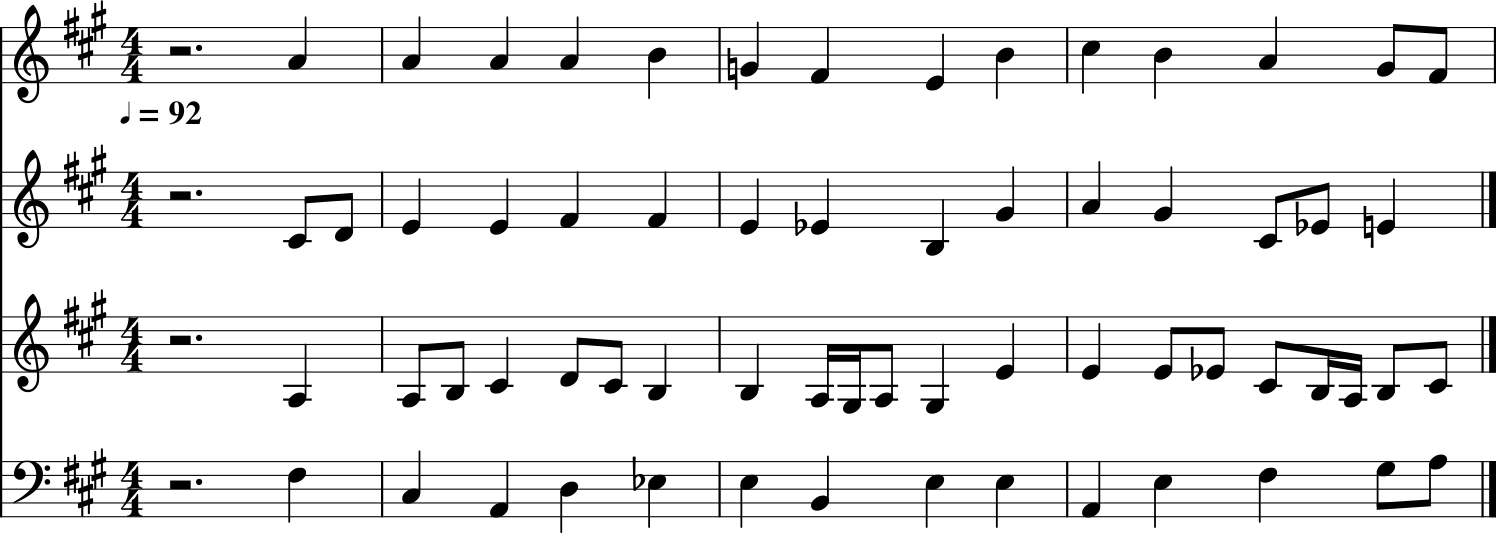

In [8]:
midiPath = "data/Bach_Chorales/003706b_.mid"
notesMatrix,tempoMatrix = getChoralFeatures(midiPath)
m21.converter.parse(midiPath).measures(0,4).show()

In [15]:
s = features2midi(notesMatrix, tempoMatrix)
name = "test3.mid"
s.write("midi", "Compositions/MarkovModels/"+name)

'Compositions/MarkovModels/test3.mid'

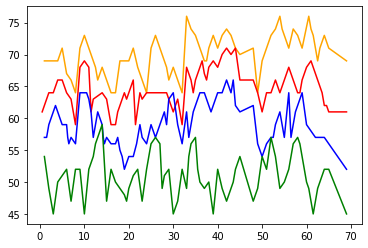

In [16]:
plt.plot(np.cumsum(tempoMatrix[0]), notesMatrix[0],'orange')
plt.plot(np.cumsum(tempoMatrix[1]), notesMatrix[1],'r')
plt.plot(np.cumsum(tempoMatrix[2]), notesMatrix[2],'b')
plt.plot(np.cumsum(tempoMatrix[3]), notesMatrix[3],'g')

In [7]:
#/!\ This section of code was mainly taken from 
#/!\ https://colab.research.google.com/github/cpmpercussion/creative-prediction/blob/master/notebooks/3-zeldic-musical-RNN.ipynb#scrollTo=bfExQmLEPl7g
#/!\ The modifications only permit to extend this representation to a multiple voices representation (like for a choral)
#/!\ Thanks !

MELODY_NOTE_OFF = 128 # (stop playing all previous notes)
MELODY_NO_EVENT = 129 # (no change from previous event)
# Each element in the sequence lasts for one sixteenth note.

def streamToNoteArray(stream):
    """
    Convert a Music21 sequence to a numpy array of int8s into Melody-RNN format:
        0-127 - note on at specified pitch
        128   - note off
        129   - no event
    """
    # Part one, extract from stream
    total_length = np.int(np.round(stream.flat.highestTime / 0.25)) # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, m21.note.Note):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.pitch.midi])
        elif isinstance(element, m21.chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=np.int)
    df = pd.DataFrame({'pos': np_stream_list.T[0], 'dur': np_stream_list.T[1], 'pitch': np_stream_list.T[2]})
    df = df.sort_values(['pos','pitch'], ascending=[True, False]) # sort the dataframe properly
    df = df.drop_duplicates(subset=['pos']) # drop duplicate values
    # part 2, convert into a sequence of note events
    output = np.zeros(total_length+1, dtype=np.int16) + np.int16(MELODY_NO_EVENT)  # set array full of no events by default.
    # Fill in the output list
    for i in range(total_length):
        if not df[df.pos==i].empty:
            n = df[df.pos==i].iloc[0] # pick the highest pitch at each semiquaver
            output[i] = n.pitch # set note on
            output[i+n.dur] = MELODY_NOTE_OFF
    return output

def midi2ChoralArray(midiPath) :
    a = np.array([streamToNoteArray(m21.converter.parse(midiPath).parts[i]) for i in range(len(m21.converter.parse(midiPath).parts))])
    return a

def noteArrayToDataFrame(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a dataframe.
    """
    df = pd.DataFrame({"code": note_array})
    df['offset'] = df.index
    df['duration'] = df.index
    df = df[df.code != MELODY_NO_EVENT]
    df.duration = df.duration.diff(-1) * -1 * 0.25  # calculate durations and change to quarter note fractions
    df = df.fillna(0.25)
    return df[['code','duration']]

def noteArrayToStream(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a music21 stream.
    """
    df = noteArrayToDataFrame(note_array)
    melody_stream = m21.stream.Part()
    for index, row in df.iterrows():
        if row.code == MELODY_NO_EVENT:
            new_note = m21.note.Rest() # bit of an oversimplification, doesn't produce long notes.
        elif row.code == MELODY_NOTE_OFF:
            new_note = m21.note.Rest()
        else:
            new_note = m21.note.Note(row.code)
        new_note.quarterLength = row.duration
        melody_stream.append(new_note)
    return melody_stream

def choralArrayToStream(choralArray) :
    streamFinal = m21.stream.Score()
    for noteArray in choralArray :
        stream = noteArrayToStream(noteArray)
        streamFinal.insert(0,stream)
    return streamFinal

In [49]:
from os import listdir
from os.path import isfile, join
monRepertoire = "data/Bach_Chorales/"
def createDataBase(directory) :
    fichiers = [f for f in listdir(monRepertoire) if isfile(join(monRepertoire, f))]
    encodedChoralFinal = np.zeros((4,0))
    for fichier in tqdm(fichiers) :
        try :
            midiPath=directory+fichier
            encodedChoral = midi2ChoralArray(midiPath)
            try :
                encodedChoralFinal = np.concatenate((encodedChoralFinal, encodedChoral), axis = 1)
            except Exception as e :
                print(fichier, e)
        except Exception as e2 :
            print(e2)
    return encodedChoralFinal

In [50]:
a = createDataBase(monRepertoire)

  1%|          | 3/520 [00:02<06:32,  1.32it/s]

019506b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


  2%|▏         | 8/520 [00:05<05:09,  1.66it/s]

024809bs.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


  2%|▏         | 11/520 [00:08<09:57,  1.17s/it]

076905b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


  2%|▏         | 12/520 [00:09<07:57,  1.06it/s]

006206b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


  3%|▎         | 15/520 [00:12<08:01,  1.05it/s]

006906ba.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


  3%|▎         | 18/520 [00:14<07:40,  1.09it/s]

012008ba.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 8


  4%|▎         | 19/520 [00:17<11:21,  1.36s/it]

065800b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


  4%|▍         | 21/520 [00:18<08:29,  1.02s/it]

005605b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


  4%|▍         | 22/520 [00:21<13:16,  1.60s/it]

Bwv006.3.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


  5%|▍         | 24/520 [00:24<14:33,  1.76s/it]

007514b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


  5%|▌         | 26/520 [00:26<09:23,  1.14s/it]

019412b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


  5%|▌         | 28/520 [00:27<08:18,  1.01s/it]

070100b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 3


  6%|▌         | 29/520 [00:28<08:35,  1.05s/it]

064600b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


  7%|▋         | 35/520 [00:35<12:05,  1.50s/it]

069400b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


  8%|▊         | 39/520 [00:47<29:23,  3.67s/it]

065600b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


  8%|▊         | 41/520 [00:48<17:31,  2.20s/it]

010107b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 6


  8%|▊         | 42/520 [00:50<15:55,  2.00s/it]

069000b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


  8%|▊         | 43/520 [00:51<13:23,  1.68s/it]

Bwv030.6.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


  9%|▊         | 45/520 [00:55<16:26,  2.08s/it]

014004b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


  9%|▉         | 47/520 [00:57<11:10,  1.42s/it]

Bwv027.6.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


  9%|▉         | 48/520 [00:58<10:06,  1.28s/it]

064800b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 11%|█         | 55/520 [01:03<06:22,  1.21it/s]

009709b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


 11%|█         | 57/520 [01:05<07:29,  1.03it/s]

009207b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 11%|█▏        | 59/520 [01:06<06:40,  1.15it/s]

006404b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 12%|█▏        | 60/520 [01:07<05:35,  1.37it/s]

069100b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 3


 12%|█▏        | 61/520 [01:16<26:19,  3.44s/it]

013701b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 12%|█▏        | 63/520 [01:18<16:03,  2.11s/it]

015905b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 13%|█▎        | 66/520 [01:20<08:51,  1.17s/it]

024429bb.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 13%|█▎        | 68/520 [01:23<09:46,  1.30s/it]

017507b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


 13%|█▎        | 69/520 [01:24<08:44,  1.16s/it]

Bwv031.9.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 16%|█▌        | 81/520 [01:33<07:16,  1.01it/s]

cannot find a format extensions for: /home/homer/Documents/Projets/Music_Generation/data/Bach_Chorales/.DS_Store


 17%|█▋        | 86/520 [01:38<09:30,  1.31s/it]

006906b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 8


 18%|█▊        | 95/520 [01:49<15:35,  2.20s/it]

010006b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 20%|██        | 105/520 [01:56<04:05,  1.69it/s]

017206vn.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 1


 20%|██        | 106/520 [02:04<20:04,  2.91s/it]

024864b6.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 21%|██        | 109/520 [02:07<11:12,  1.64s/it]

Bwv033.6.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 22%|██▏       | 113/520 [02:10<07:17,  1.07s/it]

Bwv011.6.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 22%|██▏       | 116/520 [02:18<12:35,  1.87s/it]

005903b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


 22%|██▎       | 117/520 [02:19<12:12,  1.82s/it]

024823b2.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 23%|██▎       | 121/520 [02:22<06:32,  1.02it/s]

024817b2.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 6


 25%|██▍       | 128/520 [02:29<06:13,  1.05it/s]

018405b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 25%|██▍       | 129/520 [02:30<06:08,  1.06it/s]

017906b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 25%|██▌       | 131/520 [02:35<13:20,  2.06s/it]

007903b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 25%|██▌       | 132/520 [02:39<15:29,  2.39s/it]

065000b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 27%|██▋       | 138/520 [02:49<16:16,  2.56s/it]

014710b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 27%|██▋       | 142/520 [02:53<09:32,  1.51s/it]

Bwv030.6v.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 28%|██▊       | 144/520 [03:00<16:31,  2.64s/it]

065500b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 28%|██▊       | 145/520 [03:06<22:45,  3.64s/it]

073300b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 29%|██▉       | 150/520 [03:10<08:06,  1.31s/it]

017206b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 29%|██▉       | 151/520 [03:11<08:00,  1.30s/it]

013705b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 8


 30%|██▉       | 155/520 [03:14<05:59,  1.02it/s]

024805b1.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 32%|███▏      | 165/520 [03:23<08:02,  1.36s/it]

060800qt .mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 32%|███▏      | 168/520 [03:31<15:17,  2.61s/it]

013807b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 33%|███▎      | 173/520 [03:35<06:32,  1.13s/it]

011704v1.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 33%|███▎      | 174/520 [03:39<11:54,  2.06s/it]

024842b4.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 35%|███▌      | 184/520 [03:48<07:14,  1.29s/it]

066800com.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 38%|███▊      | 196/520 [03:59<07:26,  1.38s/it]

070000b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 38%|███▊      | 199/520 [04:02<05:15,  1.02it/s]

011704v2.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 40%|███▉      | 206/520 [04:10<08:48,  1.68s/it]

007614b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 8


 40%|████      | 208/520 [04:37<46:06,  8.87s/it]

Bwv001.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 41%|████      | 212/520 [04:41<14:39,  2.85s/it]

007206b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 42%|████▏     | 217/520 [04:46<08:16,  1.64s/it]

010506b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 44%|████▍     | 229/520 [04:55<03:54,  1.24it/s]

009507b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 44%|████▍     | 230/520 [04:57<06:46,  1.40s/it]

066000b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 48%|████▊     | 250/520 [05:19<05:37,  1.25s/it]

012106b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 49%|████▉     | 254/520 [05:24<07:23,  1.67s/it]

Bwv024.6.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 50%|████▉     | 258/520 [05:31<08:34,  1.97s/it]

066100b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 53%|█████▎    | 276/520 [05:46<07:04,  1.74s/it]

066200b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 53%|█████▎    | 278/520 [05:55<14:15,  3.53s/it]

065200b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 54%|█████▍    | 280/520 [05:59<11:08,  2.78s/it]

017106b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 55%|█████▍    | 284/520 [06:03<05:28,  1.39s/it]

005206b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 6


 55%|█████▍    | 285/520 [06:04<05:06,  1.30s/it]

018405bv.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 56%|█████▌    | 289/520 [06:08<04:40,  1.22s/it]

Bwv001.6.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


 58%|█████▊    | 302/520 [06:18<02:38,  1.38it/s]

010107bv.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 6


 60%|█████▉    | 310/520 [06:40<20:25,  5.83s/it]

014001b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 60%|██████    | 312/520 [06:44<14:04,  4.06s/it]

004106b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 60%|██████    | 314/520 [06:45<07:51,  2.29s/it]

006206bv.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 61%|██████▏   | 319/520 [06:50<04:10,  1.24s/it]

013006b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 8


 62%|██████▏   | 321/520 [06:52<03:39,  1.10s/it]

025000b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


 62%|██████▏   | 322/520 [06:56<06:08,  1.86s/it]

010707b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 63%|██████▎   | 326/520 [07:01<05:36,  1.74s/it]

066600b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 64%|██████▍   | 335/520 [07:11<04:44,  1.54s/it]

Bwv029.8.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 8


 65%|██████▍   | 337/520 [07:13<03:30,  1.15s/it]

024514b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 66%|██████▌   | 341/520 [07:15<02:05,  1.43it/s]

Bwv026.6.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 66%|██████▋   | 345/520 [07:19<02:26,  1.19it/s]

013606b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 6


 67%|██████▋   | 347/520 [07:20<02:40,  1.08it/s]

016106b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 6


 67%|██████▋   | 349/520 [07:25<04:45,  1.67s/it]

065300b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 68%|██████▊   | 354/520 [07:29<02:57,  1.07s/it]

017206ch.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 69%|██████▊   | 357/520 [07:32<02:34,  1.06it/s]

022703b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 69%|██████▉   | 358/520 [07:33<02:34,  1.05it/s]

Bwv012.7.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 69%|██████▉   | 360/520 [07:35<02:38,  1.01it/s]

024859b6.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 70%|██████▉   | 362/520 [07:38<03:12,  1.22s/it]

004207b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 72%|███████▏  | 373/520 [07:50<04:25,  1.81s/it]

012905b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 74%|███████▎  | 383/520 [08:04<06:49,  2.99s/it]

024864qt.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 74%|███████▍  | 386/520 [08:06<03:35,  1.61s/it]

007011b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


 74%|███████▍  | 387/520 [08:09<04:13,  1.91s/it]

013702b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 75%|███████▌  | 391/520 [08:15<04:17,  2.00s/it]

019007b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 9


 76%|███████▌  | 395/520 [08:27<07:40,  3.68s/it]

065100b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


 76%|███████▌  | 396/520 [08:29<07:09,  3.46s/it]

066700b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 77%|███████▋  | 399/520 [08:33<04:16,  2.12s/it]

004606b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 8


 77%|███████▋  | 400/520 [08:35<03:54,  1.96s/it]

024809b1.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 77%|███████▋  | 401/520 [08:37<03:51,  1.95s/it]

064900b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 78%|███████▊  | 408/520 [08:45<03:25,  1.84s/it]

010602b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 79%|███████▉  | 412/520 [08:48<01:49,  1.01s/it]

011506b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 80%|███████▉  | 414/520 [08:50<01:45,  1.00it/s]

076901b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 80%|███████▉  | 415/520 [08:53<02:30,  1.43s/it]

014907b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 8


 81%|████████  | 419/520 [08:55<01:28,  1.14it/s]

012206b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 82%|████████▏ | 427/520 [09:01<01:11,  1.31it/s]

007906b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


 83%|████████▎ | 430/520 [09:05<01:41,  1.13s/it]

Bwv019.7.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


 83%|████████▎ | 432/520 [09:07<01:30,  1.03s/it]

025100b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 6


 83%|████████▎ | 433/520 [09:08<01:29,  1.03s/it]

076902b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 3


 84%|████████▎ | 435/520 [09:09<01:23,  1.02it/s]

018506b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 84%|████████▍ | 436/520 [09:10<01:15,  1.12it/s]

024503b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 84%|████████▍ | 437/520 [09:12<01:32,  1.11s/it]

025200b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


 84%|████████▍ | 439/520 [09:14<01:22,  1.02s/it]

004507b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 86%|████████▌ | 446/520 [09:27<03:46,  3.06s/it]

009801b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 86%|████████▌ | 447/520 [09:35<05:50,  4.80s/it]

066300b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 86%|████████▌ | 448/520 [09:40<05:34,  4.64s/it]

065700b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 86%|████████▋ | 449/520 [09:41<04:17,  3.62s/it]

Bwv008.6.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 87%|████████▋ | 450/520 [09:50<06:00,  5.15s/it]

022709b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 87%|████████▋ | 453/520 [10:12<07:38,  6.84s/it]

009106b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


 87%|████████▋ | 454/520 [10:53<18:48, 17.10s/it]

066500b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 88%|████████▊ | 455/520 [11:02<15:55, 14.71s/it]

024812b2.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 88%|████████▊ | 456/520 [11:24<18:07, 16.99s/it]

064700b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 89%|████████▉ | 464/520 [12:23<07:04,  7.58s/it]

024835b3.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 89%|████████▉ | 465/520 [12:31<07:10,  7.82s/it]

011704b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 90%|█████████ | 468/520 [12:54<07:07,  8.22s/it]

011205b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 7


 90%|█████████ | 469/520 [13:09<08:47, 10.34s/it]

024310b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 6


 91%|█████████ | 471/520 [14:02<16:34, 20.29s/it]

065400b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 91%|█████████▏| 475/520 [14:36<08:43, 11.64s/it]

017705b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 92%|█████████▏| 479/520 [15:03<06:01,  8.81s/it]

066800b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 93%|█████████▎| 484/520 [16:02<08:31, 14.22s/it]

007507b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 93%|█████████▎| 486/520 [16:16<06:00, 10.61s/it]

012406b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 94%|█████████▍| 489/520 [16:37<04:26,  8.61s/it]

006106b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 6


 95%|█████████▍| 492/520 [17:24<07:22, 15.80s/it]

064500b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 95%|█████████▍| 493/520 [18:16<11:58, 26.63s/it]

014706b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 96%|█████████▌| 497/520 [18:40<04:11, 10.95s/it]

Bwv013.6.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 96%|█████████▌| 500/520 [19:03<02:51,  8.58s/it]

024505b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 96%|█████████▋| 501/520 [19:13<02:51,  9.03s/it]

017705bv.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 97%|█████████▋| 505/520 [19:42<02:00,  8.02s/it]

011506bv.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


 98%|█████████▊| 508/520 [20:01<01:30,  7.51s/it]

012805b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 6


 98%|█████████▊| 509/520 [20:34<02:44, 14.99s/it]

007607b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 8


 99%|█████████▊| 513/520 [21:35<02:13, 19.09s/it]

013703b_.mid all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


 99%|█████████▉| 517/520 [22:05<00:31, 10.62s/it]

073800b_.mid all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5


100%|██████████| 520/520 [22:20<00:00,  2.58s/it]


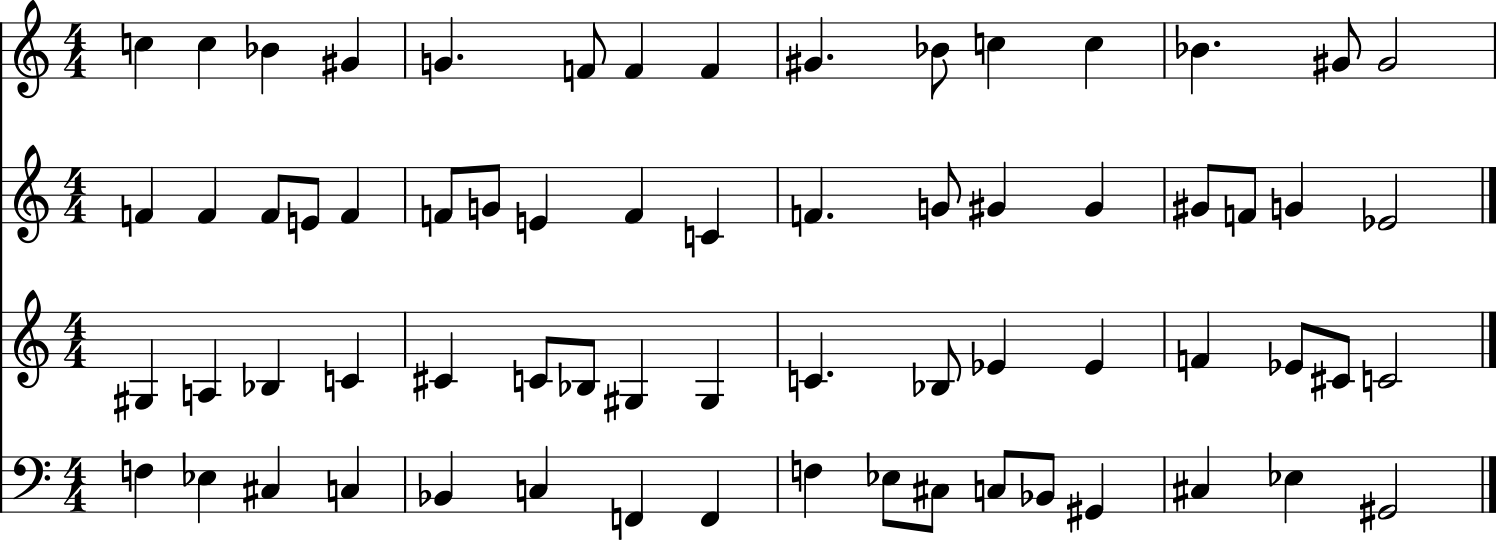

In [8]:
midiPath = "data/Bach_Chorales/004008b_.mid"
machin = midi2ChoralArray(midiPath)
choralArrayToStream(machin).measures(0,4).show()